In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
import random
import glob
import pickle
import itertools
import io
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas
import time
from tqdm import tqdm

import sklearn

import tensorflow as tf
import tf_data


In [4]:
import tensorflow as tf
import json, os
import numpy as np

# Tested with TensorFlow 2.1.0
print('version={}, CUDA={}, GPU={}, TPU={}'.format(
    tf.__version__, tf.test.is_built_with_cuda(),
    # GPU attached?
    len(tf.config.list_physical_devices('GPU')) > 0,
    # TPU accessible? (only works on Colab)
    'COLAB_TPU_ADDR' in os.environ))

if len(tf.config.list_physical_devices('GPU')) > 0:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    strategy = tf.distribute.OneDeviceStrategy("gpu:0")

version=2.3.0, CUDA=True, GPU=True, TPU=False


# Dataset building

In [5]:
data_path = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v6/training/calo_matched/*.proto",
             #"gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/calo_matched/*.proto",
             #"ele_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/no_calo_matched/*.proto",
             #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
            }

In [9]:
features = [ "en_cluster","et_cluster", 
            "cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
            "cl_swissCross", "cl_nxtals", "cl_etaWidth","cl_phiWidth"]

metadata =  [  "en_true_sim","et_true_sim", "en_true_gen", "et_true_gen",
            "nclusters_insc","max_en_cluster_insc","max_deta_cluster_insc",
            "max_dphi_cluster_insc", "max_en_cluster","max_deta_cluster","max_dphi_cluster",
            "event_tot_simen_PU","wtot_simen_PU","wtot_simen_sig" ]

In [7]:
_load_n_items = 10
_batch_size = 6
_nepochs = 1
_ntrain = 10000
_nval = 1000

In [17]:
# Load a balanced dataset from the list of paths given to the function. Selected only the requestes features from clusters and prepare batches
total_ds = tf_data.load_balanced_dataset_batch(data_path, features,metadata, _batch_size)
# the indexes for energy and et are from the features list we requestes
total_ds = tf_data.delta_energy_seed(total_ds, en_index=0, et_index=1)
total_ds = tf_data.training_format(total_ds) 

In [18]:
X,y = tf_data.get(total_ds)

In [21]:
y_class, y_metadata = y

In [22]:
cl_X,cl_hits, is_seed,n_cl = X

# Graph building layer

In [67]:
from model import *
from plotting import * 

In [68]:
graph = GraphBuilding(output_dim_nodes=32)

In [54]:
rcn = RechitsGCN(nconv=3, input_dim = 4 , output_dim =12)

In [55]:
rechits = cl_hits.to_tensor()
mask_rechits, mask_cls = create_padding_masks(rechits)

In [56]:
output, (sa_output,convout, attention_weights, adj) = rcn(rechits, mask_rechits)

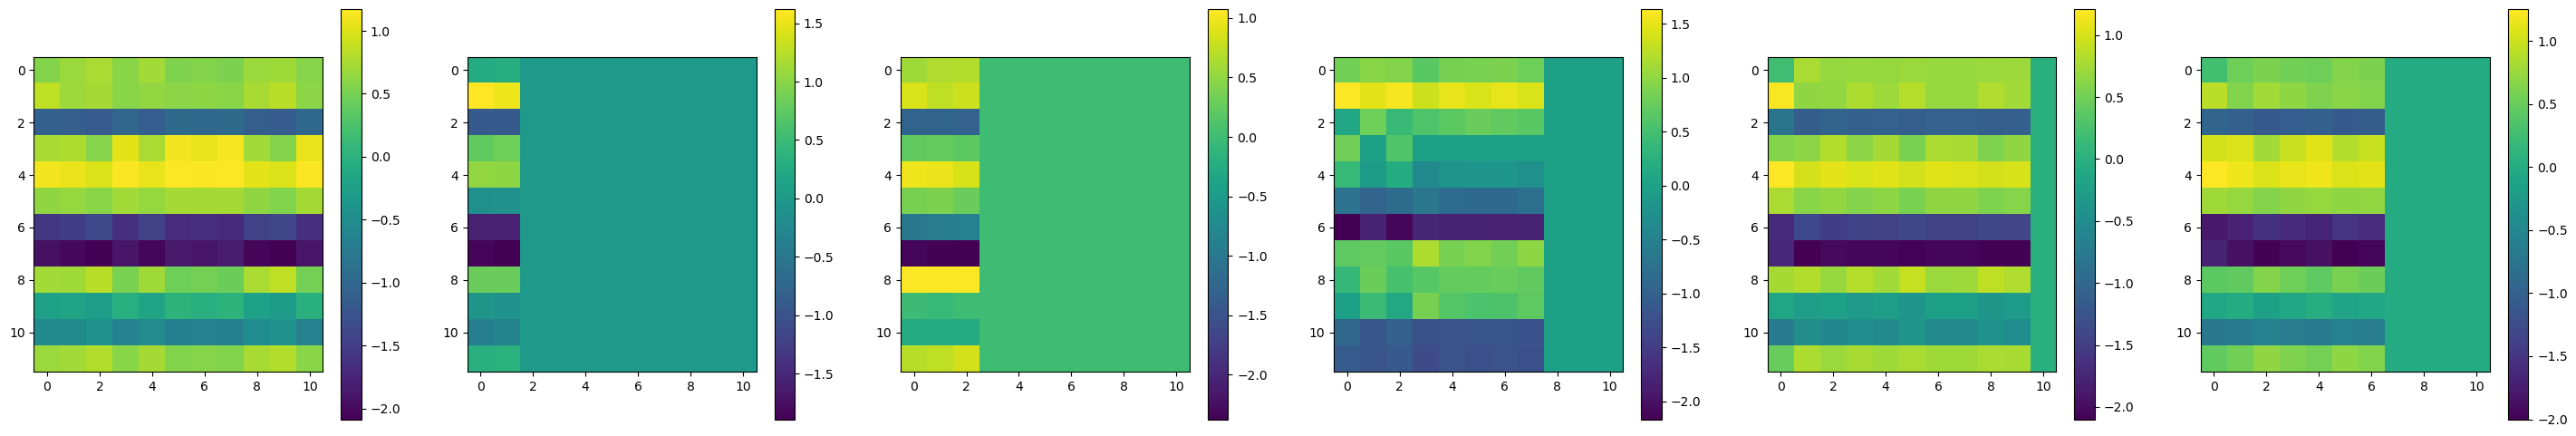

In [58]:
plotM(*output)

In [70]:
cl_x, coord, adj, mask, output_rechits, coord_att_ws = graph(X[0],X[1])

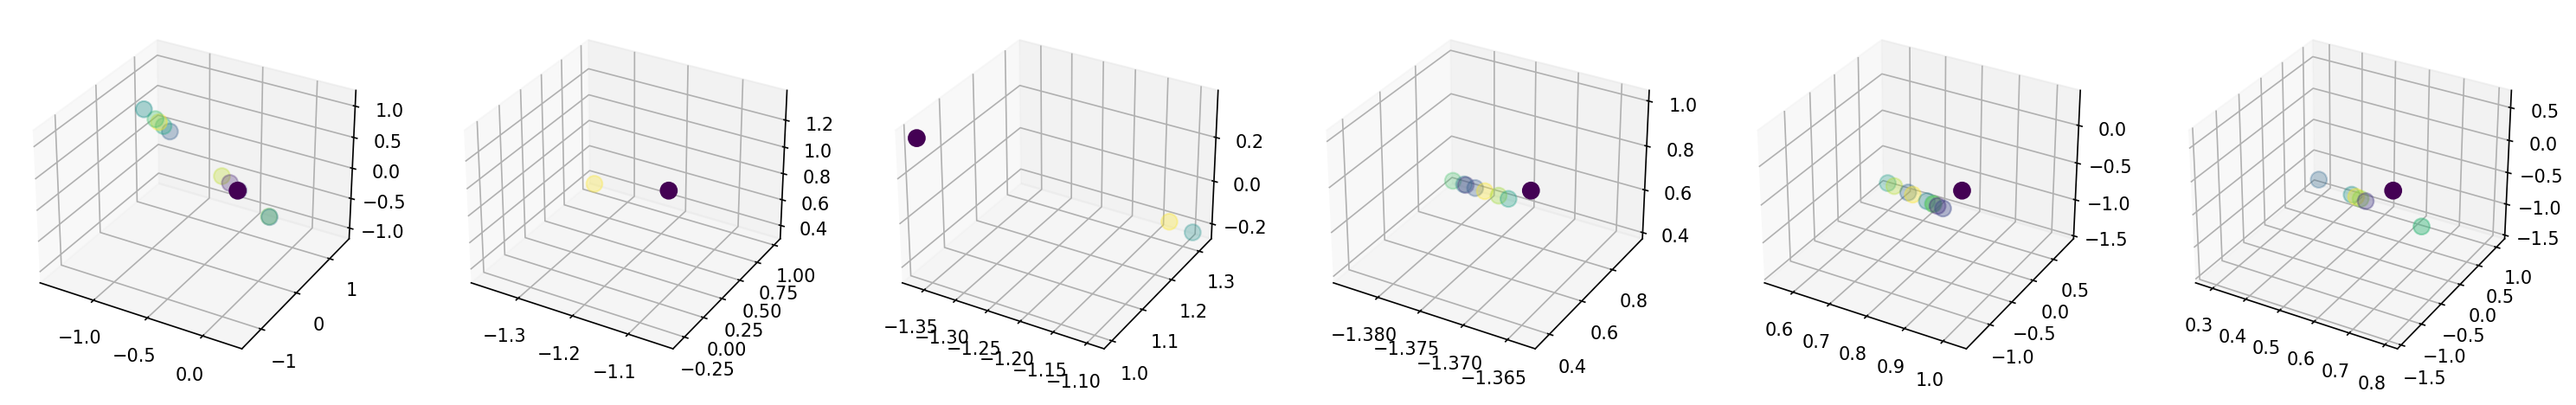

In [71]:
plot3D(coord, mask)

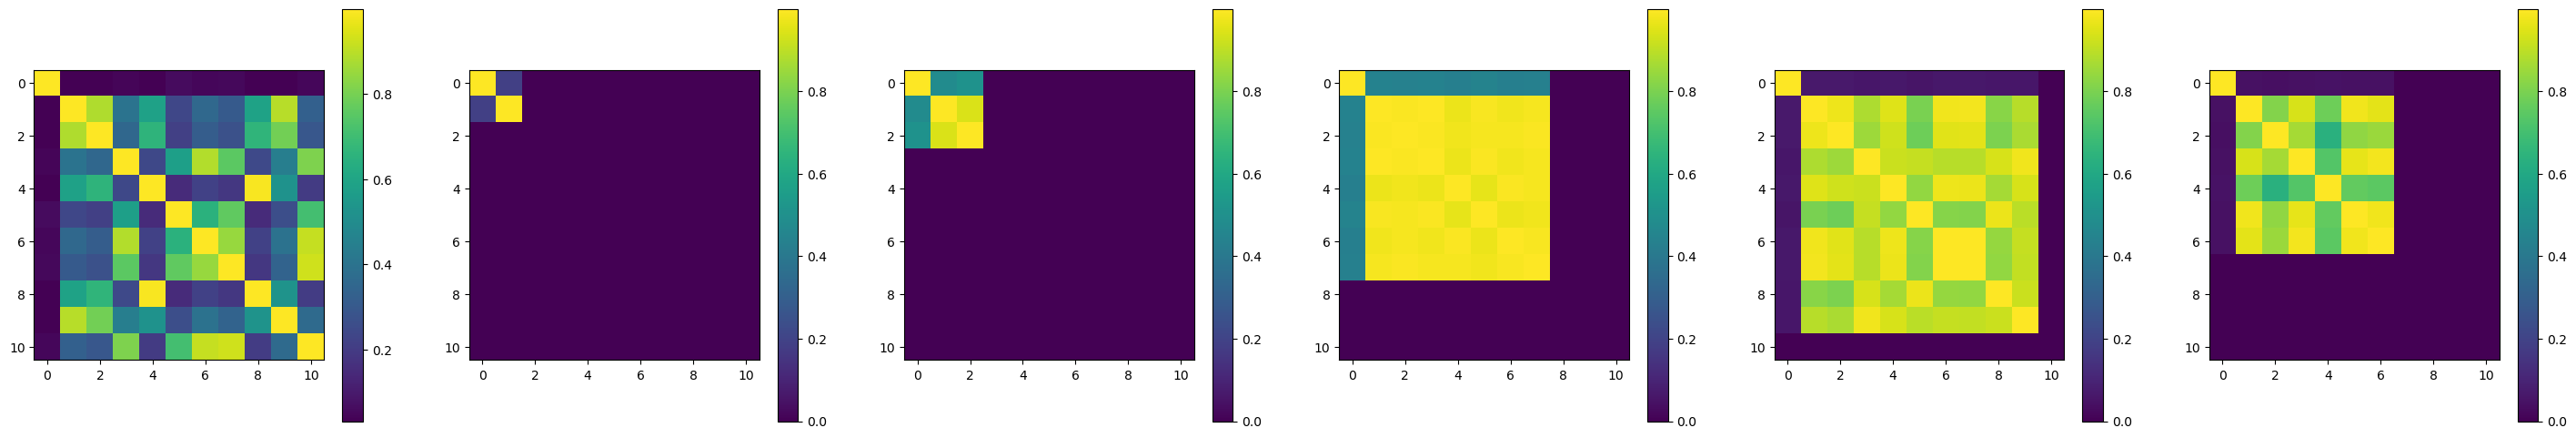

In [72]:
plotM(*adj)

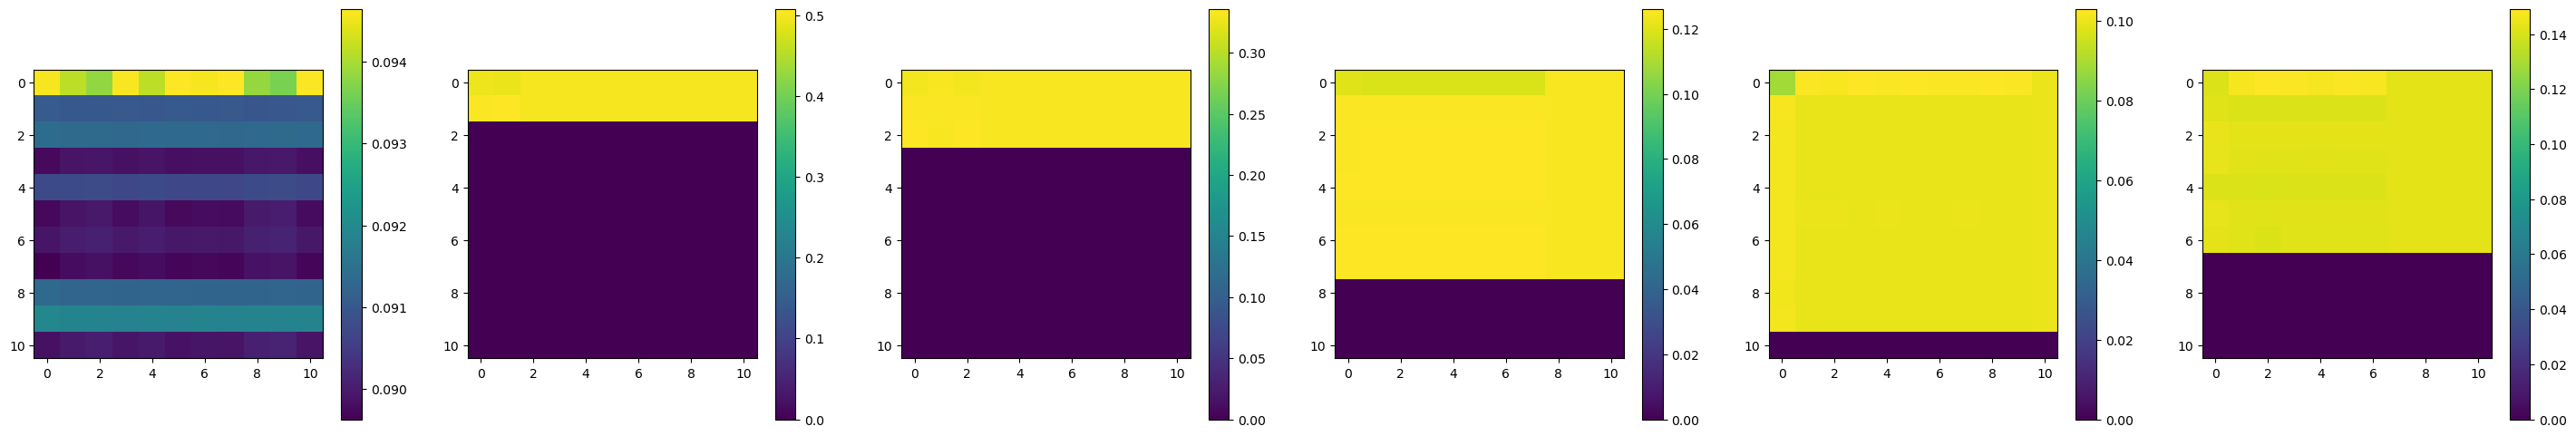

In [75]:
plotM(*coord_att_ws)

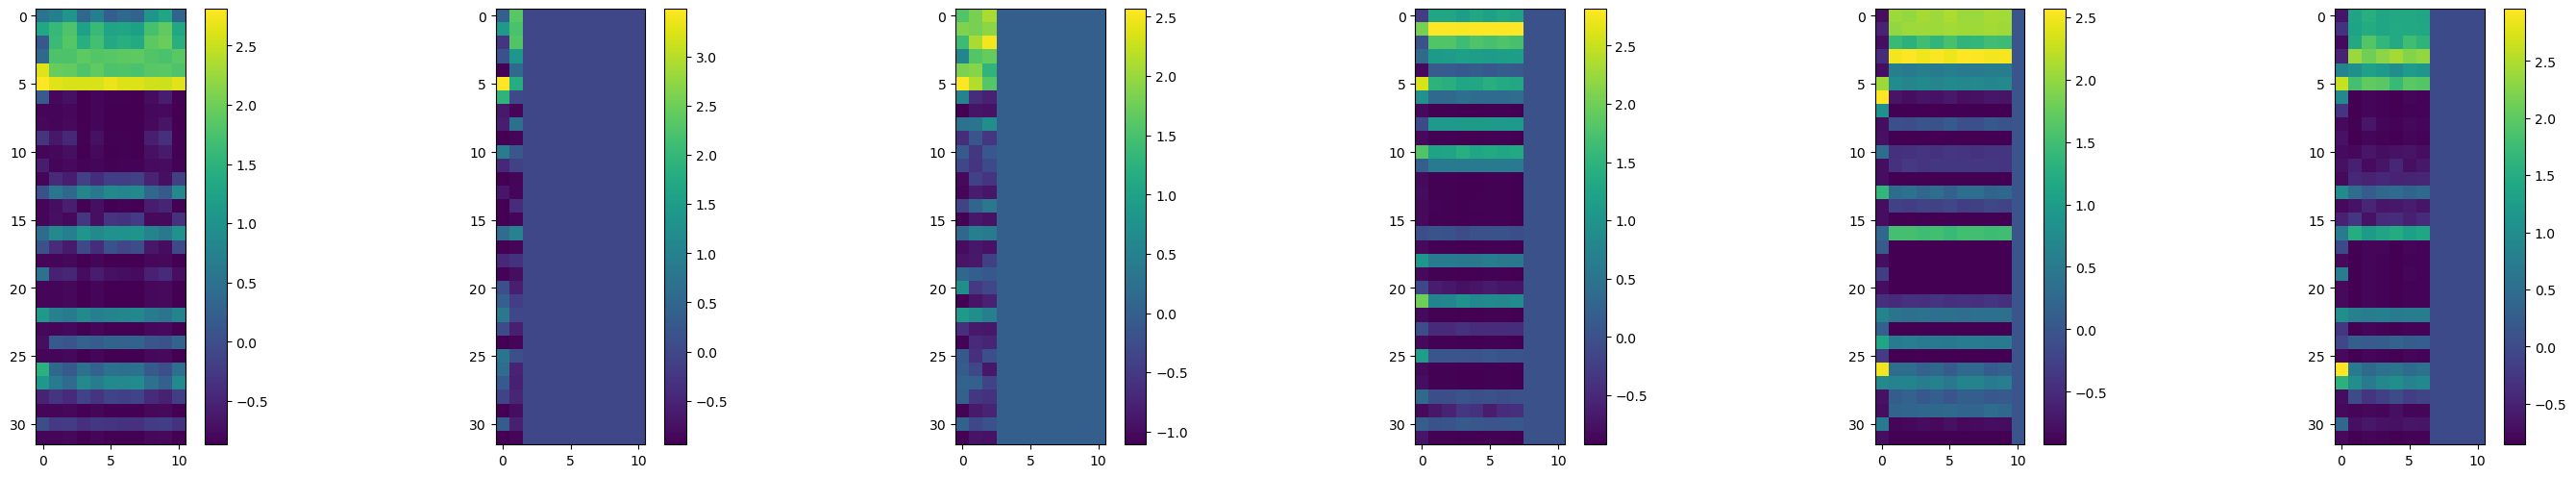

In [93]:
plotM(*cl_x)

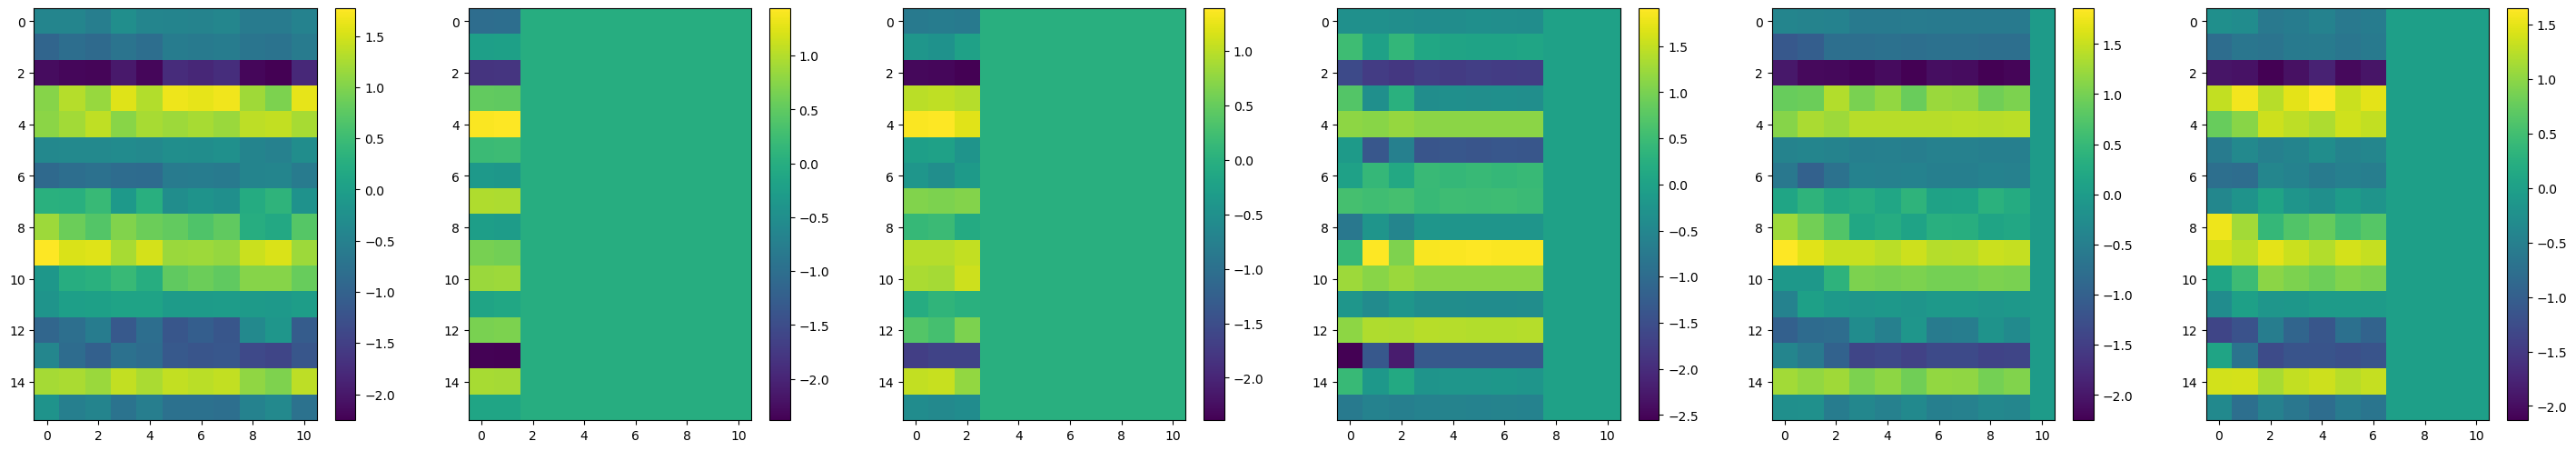

In [74]:
plotM(*output_rechits)

# Complete model

In [80]:
from model import *
from plotting import * 

In [81]:
# output_dim_nodes == latent spoace dimension for the clusters
dcgn = DeepClusterGN(nconv=3, output_dim_nodes=32, layers_input=[64,64,64], layers_coord=[64,64,64,64])

In [142]:
dense_clclass, mask_cls, (cl_X, coord, adj, coord_att_ws, output_rechits, out_gcn, out_SA, att_weights) = model(X)

In [136]:
X, y = tf_data.get(ds_train)

In [141]:
X,y = tf_data.get(ds_test)

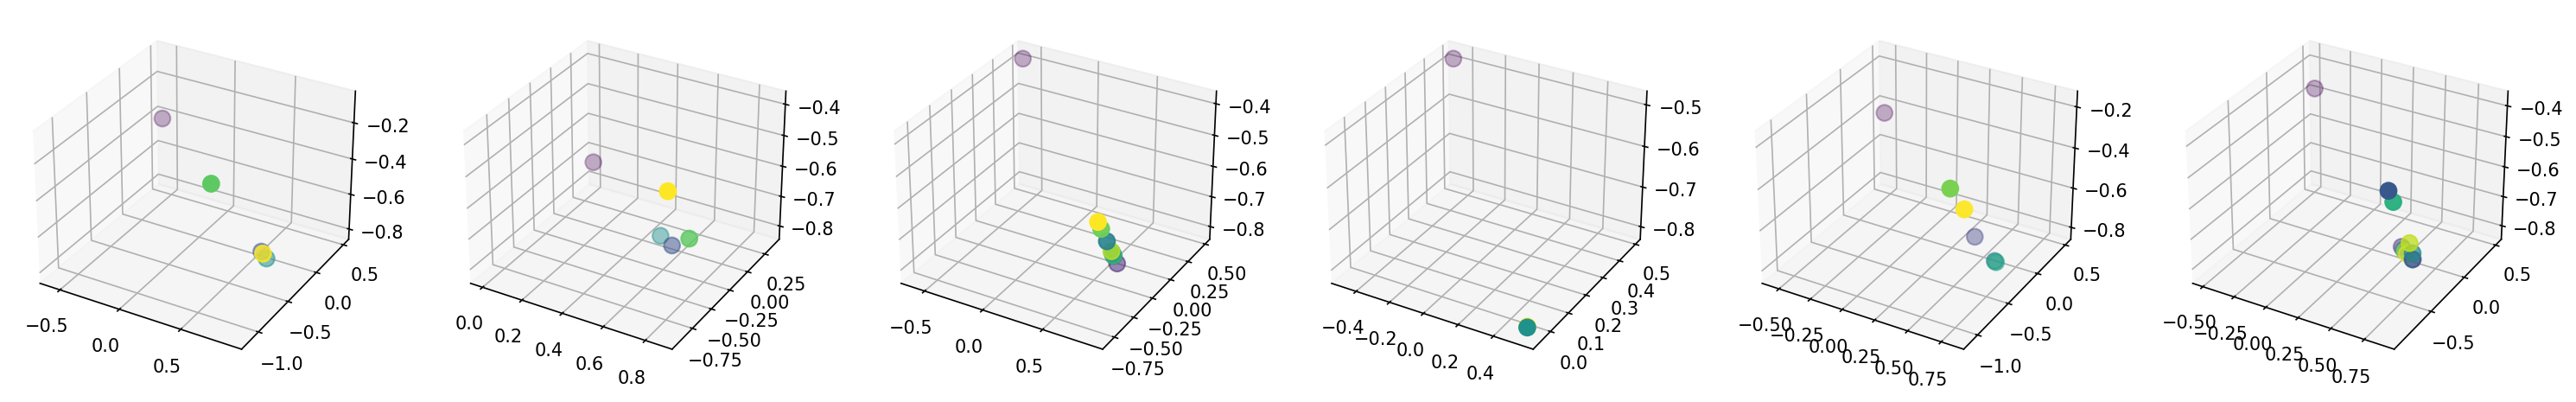

In [143]:
plot3D(coord[0:6], mask_cls)

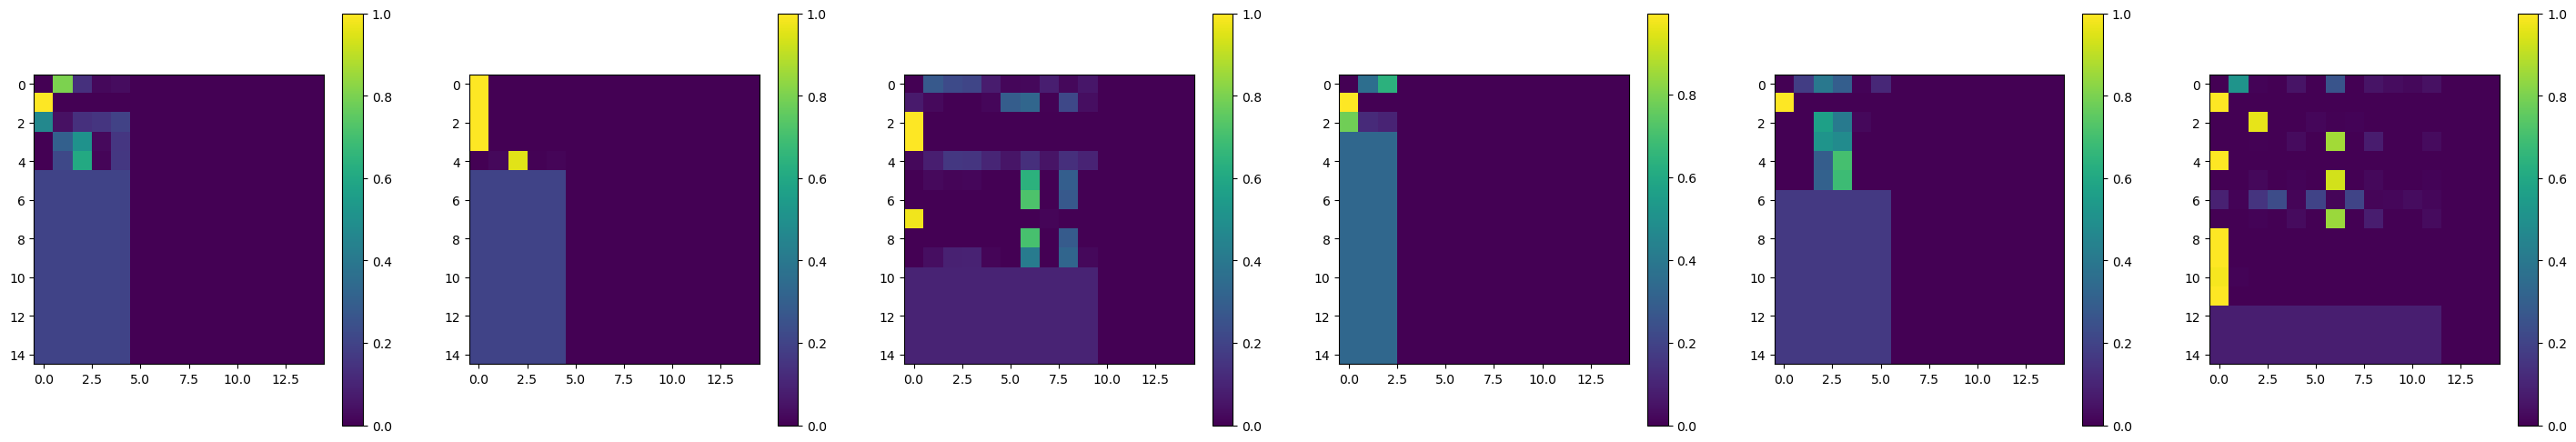

In [144]:
plotM(*coord_att_ws[0:6], t=False)

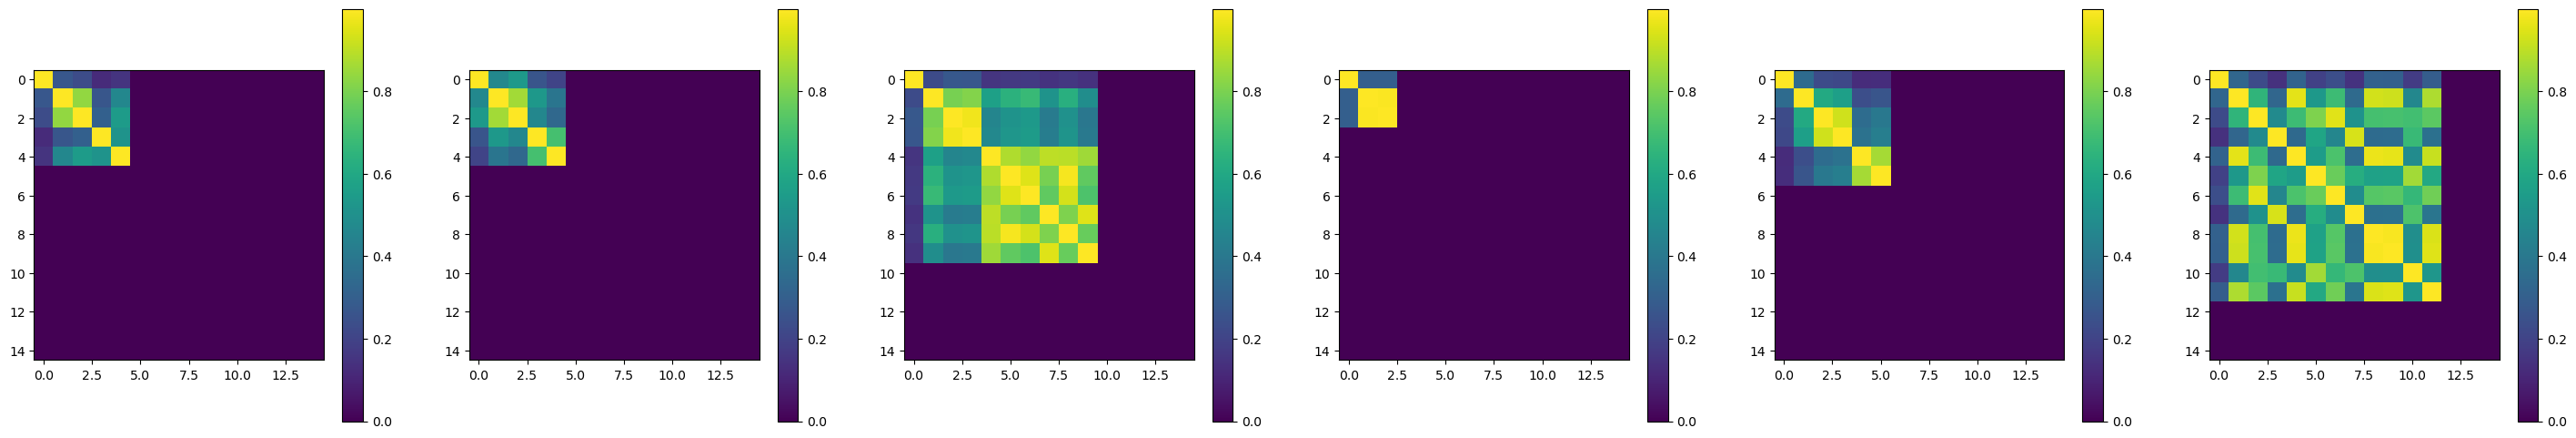

In [145]:
plotM(*adj[0:6])

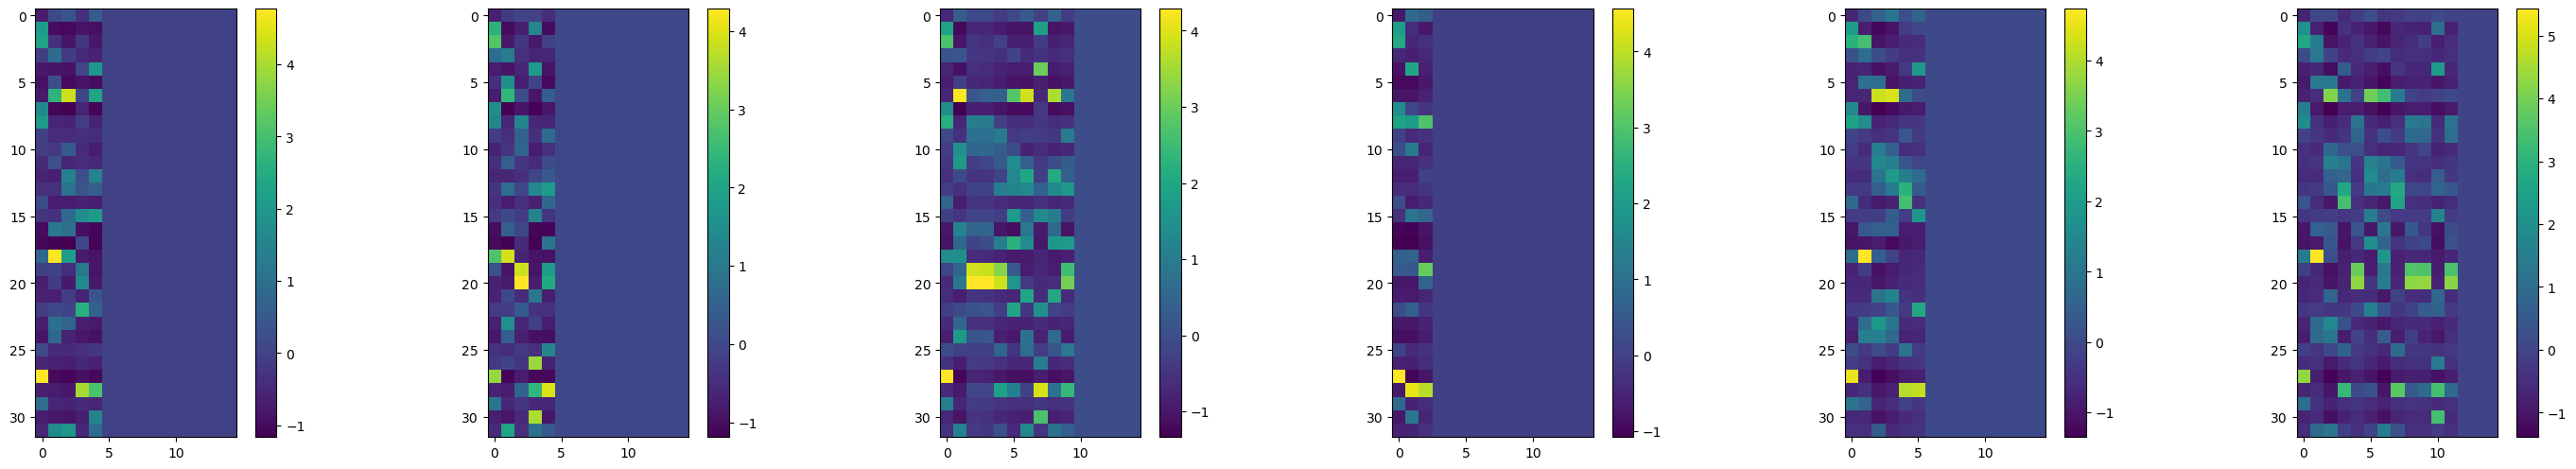

In [146]:
plotM(*cl_X[0:6])

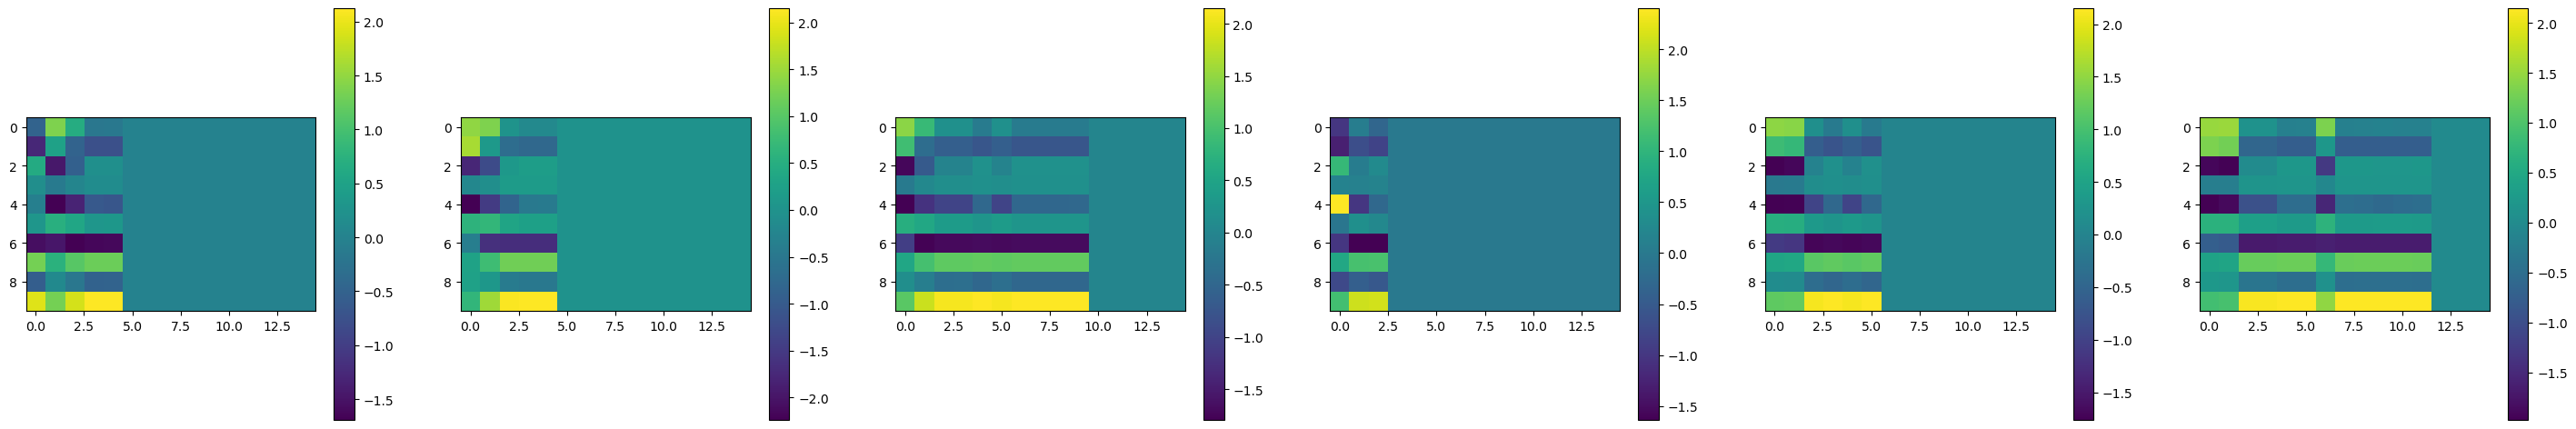

In [147]:
plotM(*output_rechits[0:6])

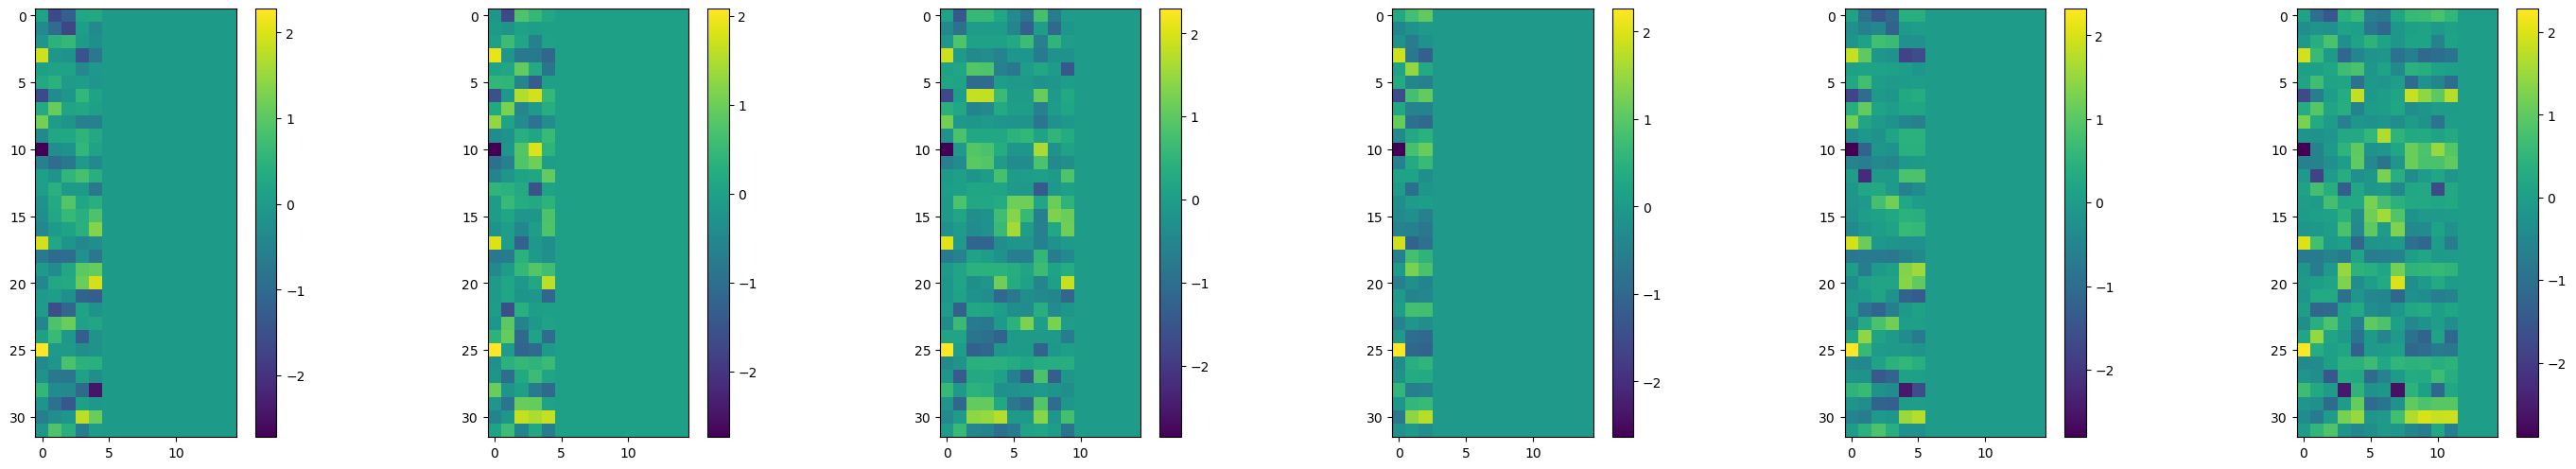

In [148]:
plotM(*out_gcn[0:6])

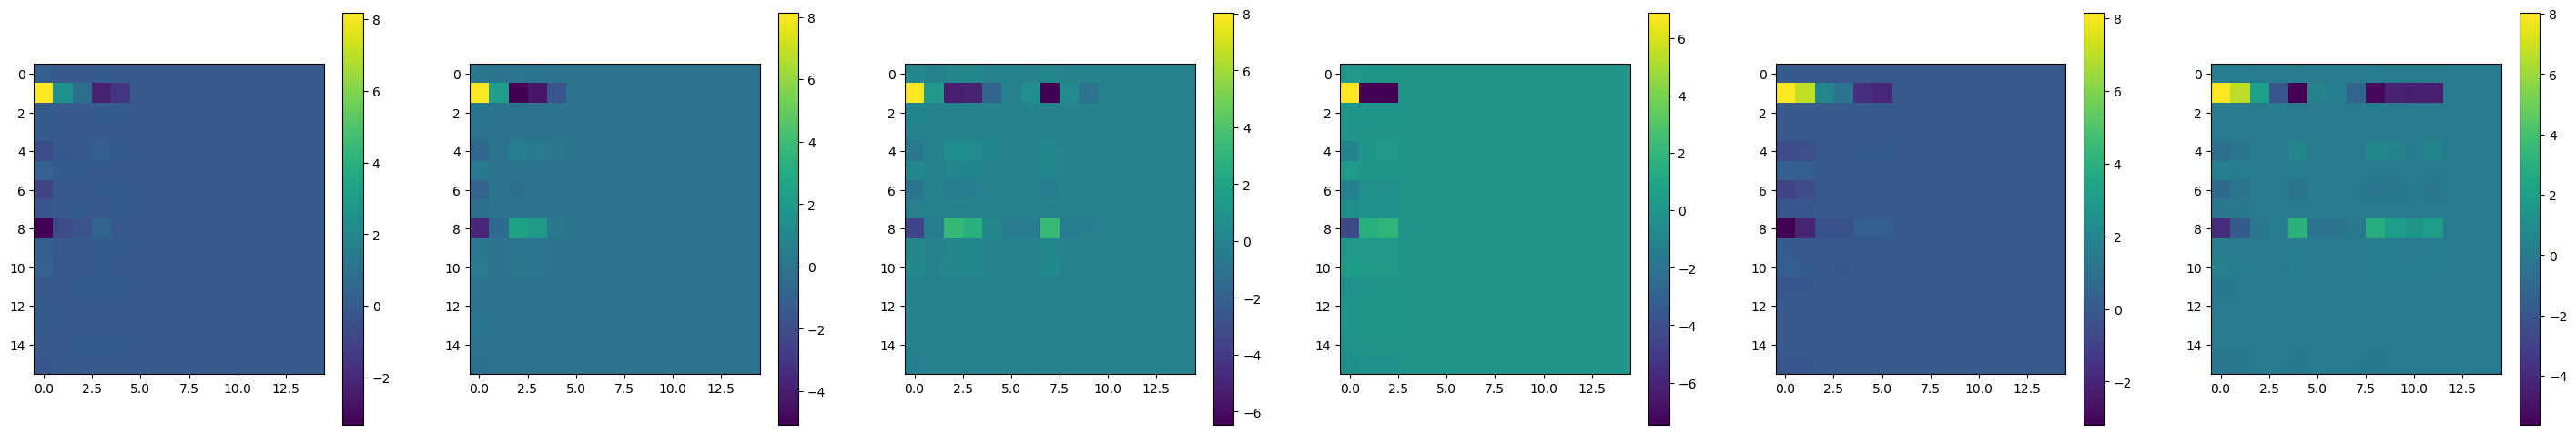

In [149]:
plotM(*out_SA[0:6])

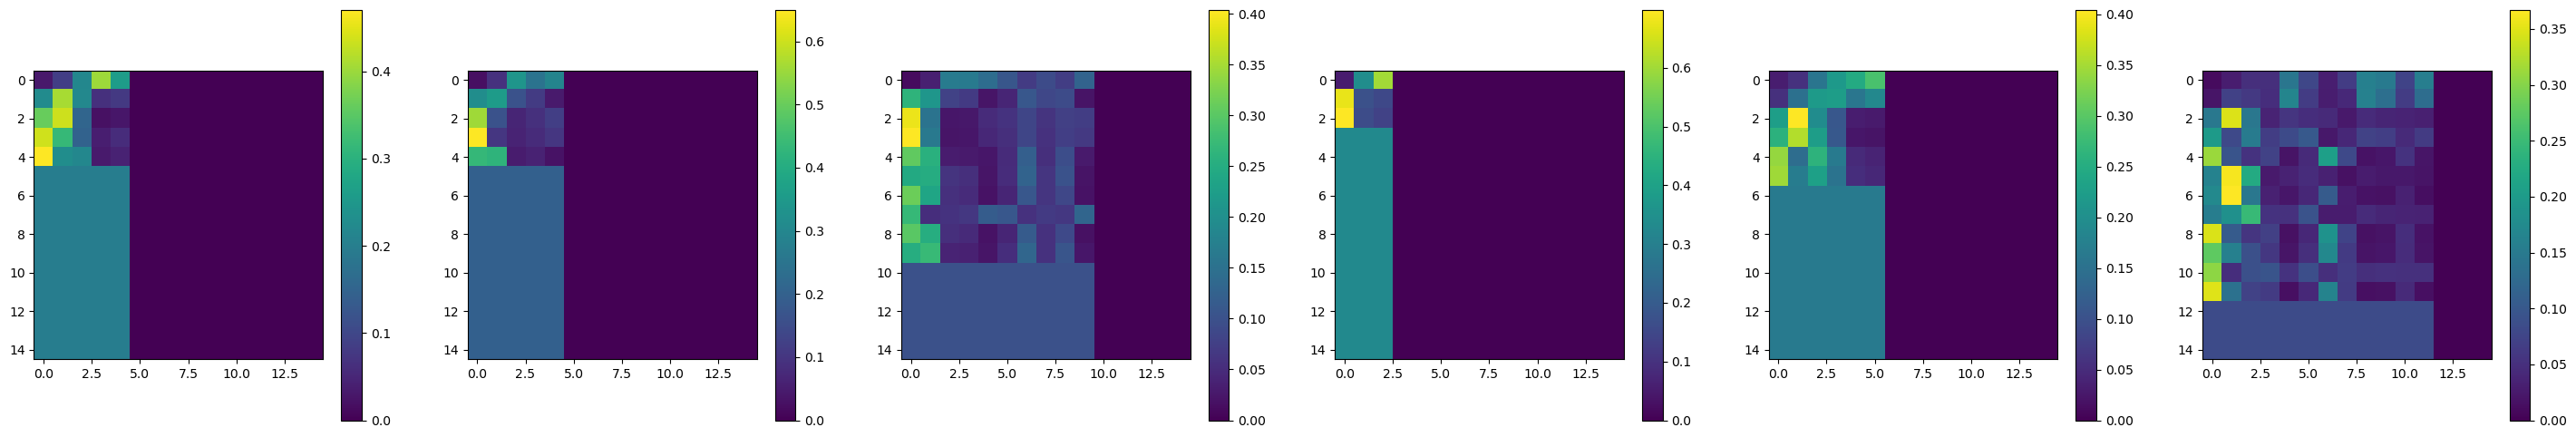

In [150]:
plotM(*att_weights[0:6], t=False)

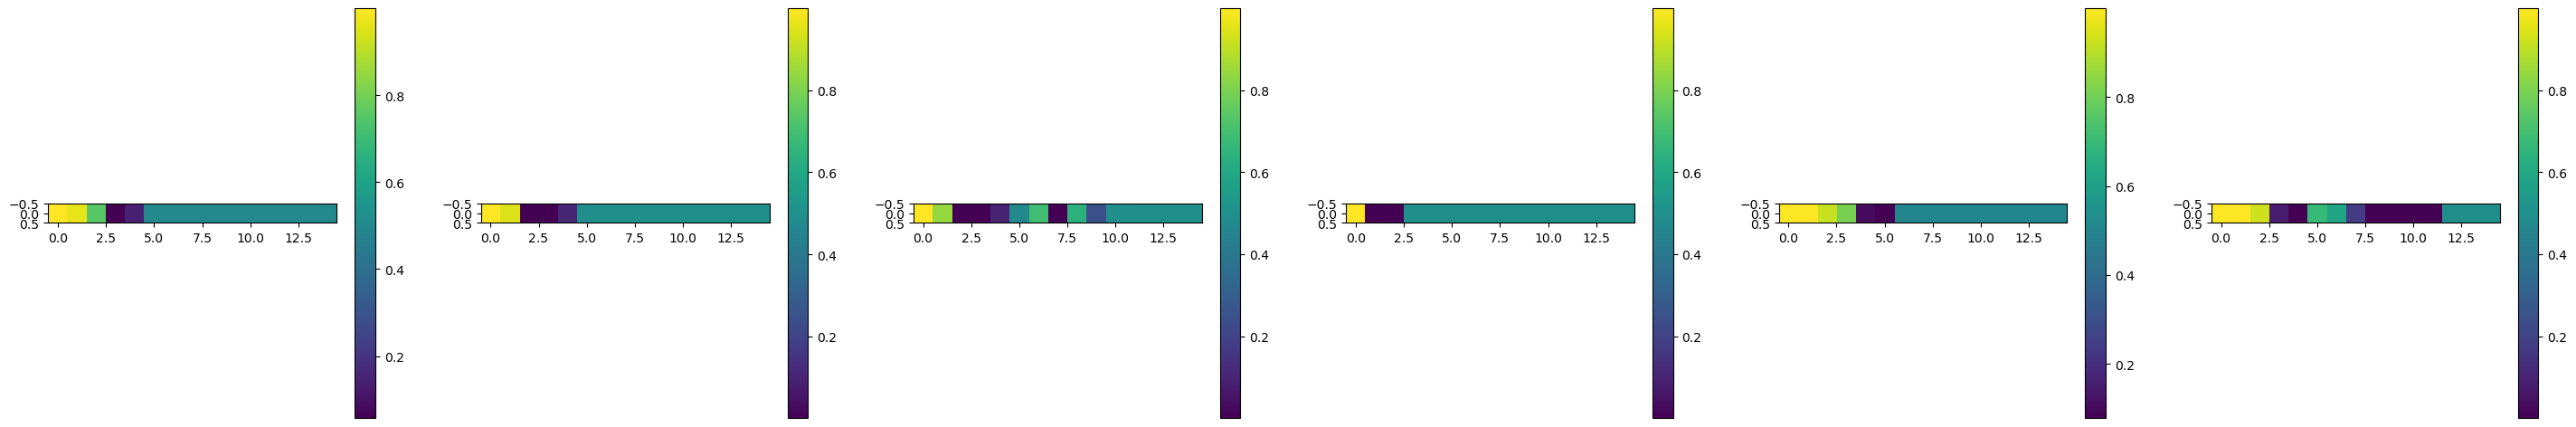

In [151]:
plotM(*tf.nn.sigmoid(dense_clclass)[0:6])

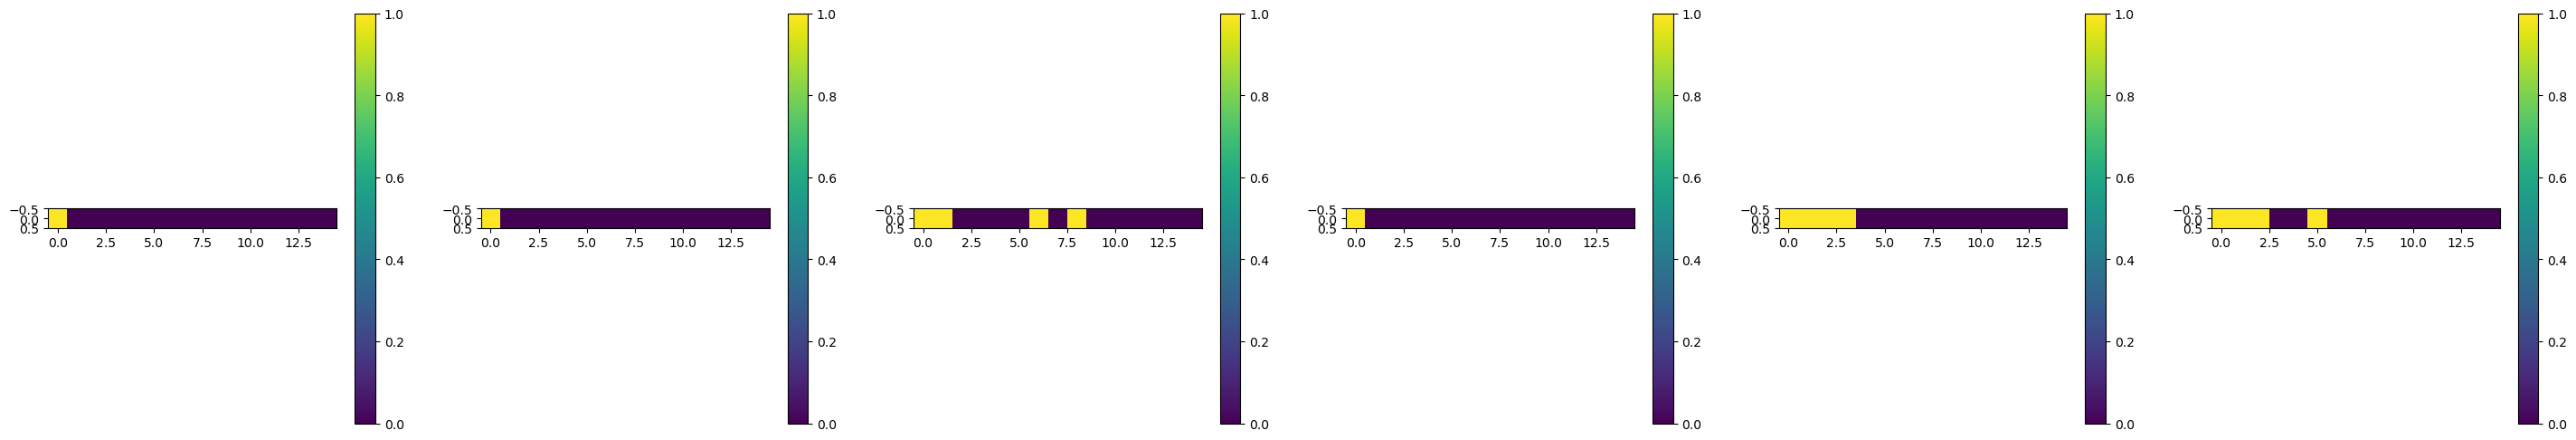

In [152]:
plotM(*y[0][0:6])

# Loss function

In [94]:
y_pred = model(X)
y_true = y 

NameError: name 'model' is not defined

In [108]:
tf.nn.sigmoid(y_pred[0][1])

<tf.Tensor: shape=(22, 1), dtype=float32, numpy=
array([[9.9999511e-01],
       [9.9999130e-01],
       [2.5416091e-03],
       [4.0850468e-02],
       [4.6317536e-01],
       [1.6885800e-03],
       [3.3386115e-02],
       [1.0887479e-03],
       [2.8428176e-04],
       [8.7211549e-02],
       [2.8373814e-01],
       [2.7363231e-02],
       [1.0307012e-02],
       [1.2715970e-03],
       [7.8995444e-02],
       [1.9795474e-01],
       [5.0000000e-01],
       [5.0000000e-01],
       [5.0000000e-01],
       [5.0000000e-01],
       [5.0000000e-01],
       [5.0000000e-01]], dtype=float32)>

In [107]:
y_true[0][1]

<tf.Tensor: shape=(22, 1), dtype=int64, numpy=
array([[1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])>

In [128]:
dense_clclass, mask_cls, _  = y_pred
y_class, y_metadata = y_true
class_loss  = tf.keras.losses.binary_crossentropy(y_class, dense_clclass, from_logits=True) * mask_cls

reduced_loss = tf.reduce_mean(tf.reduce_sum(class_loss, axis=-1))

In [129]:
class_loss

<tf.Tensor: shape=(64, 25), dtype=float32, numpy=
array([[1.3033892e-02, 1.6305754e-04, 1.6528445e-04, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.3129004e-06, 7.2896878e-06, 7.6203301e-06, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.3240897e-04, 8.2204599e+00, 8.4280186e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [1.1351465e-05, 6.7032211e-06, 1.0014297e-05, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [9.0900126e+00, 2.7997307e-06, 2.1766877e-05, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.0195195e-05, 2.0179581e-05, 2.1844506e-05, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)>

In [130]:
reduced_loss

<tf.Tensor: shape=(), dtype=float32, numpy=11.784399>

In [51]:
cl_X, cl_hits, is_seed,n_cl = X
cl_ets = cl_X[:,:,1]
cl_ets = cl_X[:,:,1] / tf.reduce_sum(cl_X[:,:,1], axis=-1)[:,tf.newaxis]
class_loss = tf.keras.losses.binary_crossentropy(y_class, dense_clclass, from_logits=True) * mask_cls
weighted_loss = class_loss * cl_ets
reduced_loss = tf.reduce_mean(tf.reduce_sum(weighted_loss, axis=-1))

In [52]:
reduced_loss

<tf.Tensor: shape=(), dtype=float32, numpy=712.43134>

In [139]:
cl_ets

<tf.Tensor: shape=(6, 9), dtype=float32, numpy=
array([[0.99097526, 0.00902472, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.9442082 , 0.01824968, 0.01601619, 0.0136416 , 0.00788432,
        0.        , 0.        , 0.        , 0.        ],
       [0.9814058 , 0.01222331, 0.0063709 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.96620196, 0.01527102, 0.01035268, 0.00817437, 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.63366574, 0.07908539, 0.0708131 , 0.04544425, 0.04703614,
        0.03674164, 0.03220187, 0.02862877, 0.02638305],
       [0.87168705, 0.03600075, 0.02746342, 0.02085922, 0.02198319,
        0.02200637, 0.        , 0.        , 0.        ]], dtype=float32)>

In [ ]:
 # true energy loss
mask_outsc = tf.cast(true_en == 0., tf.float32)
mask_insc = tf.cast(true_en != 0., tf.float32)
n_outsc = tf.reduce_sum(mask_outsc)
n_insc = tf.reduce_sum(mask_insc)

l2_en = mse_unreduced(true_en, pred_en)
l2_en_log = msle_unreduced(true_en, pred_en)

# separate mean resolution for windows with Caloparticle or not
l2_en_outsc = tf.reduce_sum(l2_en * mask_outsc) / n_outsc
l2_en_insc = tf.reduce_sum(l2_en * mask_insc) / n_insc
l2_en_outsc_log = tf.reduce_sum(l2_en_log * mask_outsc) / n_outsc
l2_en_insc_log = tf.reduce_sum(l2_en_log * mask_insc) / n_insc
    

In [ ]:
reduced_loss = tf.reduce_mean(tf.reduce_sum(class_loss, axis=-

# Test training

In [19]:
from model import *
from plotting import * 

In [23]:
models_path = "/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v2/"

#rain_steps_per_epoch = 
#eval_steps_per_epoch = 3e5 // batch_size
from collections import namedtuple
# Args = namedtuple('args', [ 'models_path', 'load','nepochs','ntrain','nval','nfeatures',
#                             'n_seed_features','batch_size','lr_decay','lr',
#                             'hidden_dim_input','hidden_dim_coord', 'hidden_dim_id',
#                             'n_layers_input', 'n_layers_id', 'n_layers_coord',
#                            'distance_dim','num_conv','dropout','convlayer',
#                            'nclass_labels', 'opt'])
Args = namedtuple('args', [ 'models_path', 'load','initial_epoch','nepochs','ntrain','nval',
                           'lr_decay','lr', 'batch_size','opt', 'debug'])


args = Args( 
models_path = models_path,
load = False,
initial_epoch = 1,
nepochs = 20,
ntrain = 300000,
nval = 30000,
# nfeatures = 13,
# n_seed_features = 12,
lr_decay = 0.5,
lr = 1e-3,
batch_size = 64,
# n_layers_input = 3,
# n_layers_id = 3,
# n_layers_coord = 3,
# hidden_dim_input = 200,
# hidden_dim_coord = 200,
# hidden_dim_id = 200,
# distance_dim = 200,
# num_conv = 2,
# dropout = 0.2,
# convlayer = 'sgconv',
# nclass_labels=2,
opt='nadam',
debug = False
        )

### Dataset loading

In [7]:
def get_unique_run():
    previous_runs = os.listdir(args.models_path)
    if len(previous_runs) == 0:
        run_number = 1
    else:
        run_number = max([int(s.split('run_')[1]) for s in previous_runs]) + 1
    return run_number


if not os.path.isdir(args.models_path):
    os.makedirs(args.models_path)

name =  'run_{:02}'.format(get_unique_run())

outdir = args.models_path + name

if os.path.isdir(outdir):
    print("Output directory exists: {}".format(outdir), file=sys.stderr)
else:
    os.makedirs(outdir)

print(outdir)

/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v2/run_03


In [8]:
data_path_train = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v6/training/calo_matched/*.proto",
                  "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v6/training/calo_matched/*.proto",
                  #"ele_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/no_calo_matched/*.proto",
                  #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
                  }
data_path_test = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v6/testing/calo_matched/*.proto",
                  "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v6/testing/calo_matched/*.proto",
                  #"ele_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/testing/no_calo_matched/*.proto",
                  #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/testing/no_calo_matched/*.proto"
                  }

In [9]:
features = [ "en_cluster","et_cluster", 
            "cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
            "cl_r9", "cl_sigmaIetaIeta", "cl_sigmaIetaIphi",
            "cl_sigmaIphiIphi","cl_swissCross",
            "cl_nxtals", "cl_etaWidth","cl_phiWidth"]


metadata =  [  "en_true_sim","et_true_sim", "en_true_gen", "et_true_gen",
            "nclusters_insc","max_en_cluster_insc","max_deta_cluster_insc",
            "max_dphi_cluster_insc", "max_en_cluster","max_deta_cluster","max_dphi_cluster",
            "event_tot_simen_PU","wtot_simen_PU","wtot_simen_sig" ]

In [10]:
# Load a balanced dataset from the list of paths given to the function. Selected only the requestes features from clusters and prepare batches
train_ds = tf_data.load_balanced_dataset_batch(data_path_train, features, metadata,  args.batch_size, weights={"ele_match":0.5,"gamma_match":0.5})
# the indexes for energy and et are from the features list we requestes
train_ds = tf_data.delta_energy_seed(train_ds, en_index=0, et_index=1)
train_ds = tf_data.training_format(train_ds)


test_ds = tf_data.load_balanced_dataset_batch(data_path_test, features, metadata, args.batch_size,weights={"ele_match":0.5,"gamma_match":0.5})
# the indexes for energy and et are from the features list we requestes
test_ds = tf_data.delta_energy_seed(test_ds, en_index=0, et_index=1)
test_ds = tf_data.training_format(test_ds)


# Create training and validation
ds_train = train_ds.prefetch(100).take(args.ntrain).repeat(args.nepochs)
ds_test  = test_ds.prefetch(100).take(args.nval).repeat(args.nepochs)

In [11]:
if args.lr_decay > 0:
        #lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        #    args.lr,
        #    decay_steps=int(args.ntrain//args.batch_size),
        #    decay_rate=args.lr_decay
        #)
        lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
            args.lr,
            decay_steps=int(args.ntrain//args.batch_size),
            decay_rate=args.lr_decay,
            staircase=True
        )
else:
    lr_schedule = args.lr


In [24]:
with strategy.scope():
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    # Construction of the model
    model = DeepClusterGN(nconv=3, output_dim_rechits=10, output_dim_nodes=32, layers_input=[64,64,32], layers_coord=[64,64], coord_dim = 3,
                          output_dim_gconv=32, output_dim_sa_class=16, layers_clclass=[64,64,32], dropout=0.2, activation=tf.keras.activations.selu)
    
  
    model.compile(optimizer=args.opt)
#         metrics=[Precision(),Recall(), energy_resolution|_insc,energy_resolution_outsc,
#                      energy_resolution_insc_log,energy_resolution_outsc_log,])
    model.set_metrics()

    for X, y in ds_train:
        ypred = model(X)
        #l = custom_loss(y, ypred)
        break

In [25]:
callbacks = []
tb = tf.keras.callbacks.TensorBoard(
    log_dir=outdir, histogram_freq=2, 
    write_graph=False, 
    write_images=True,
    update_freq='epoch',
    profile_batch=0,
)
tb.set_model(model)
callbacks += [tb]

terminate_cb = tf.keras.callbacks.TerminateOnNaN()
callbacks += [terminate_cb]

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=outdir + "/weights.{epoch:02d}-{val_loss:.6f}.hdf5",
    save_weights_only=True,
    verbose=1
)
cp_callback.set_model(model)
callbacks += [cp_callback]



In [21]:
model.summary()

Model: "deep_cluster_gn_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_building_2 (GraphBuild multiple                  9111      
_________________________________________________________________
gh_conv_i_5 (GHConvI)        multiple                  2080      
_________________________________________________________________
self_attention_4 (SelfAttent multiple                  2400      
_________________________________________________________________
sequential_12 (Sequential)   (64, 12, 1)               5313      
_________________________________________________________________
dropout_27 (Dropout)         multiple                  0         
_________________________________________________________________
layer_normalization_20 (Laye multiple                  64        
_________________________________________________________________
loss (Mean)                  multiple            

In [ ]:
if args.load:
    #ensure model input size is known
    for X, y in ds_train:
        model(X)
        break

    model.load_weights(args.load)
    
if args.nepochs > 0:
    ret = model.fit(ds_train,
        validation_data=ds_test, 
        epochs=args.nepochs,
        steps_per_epoch=args.ntrain//args.batch_size, 
        validation_steps=args.nval//args.batch_size,
        verbose=True,
        callbacks = callbacks,
        initial_epoch = args.initial_epoch
    )

Epoch 2/20
4685/4687 [============================>.] - ETA: 0s - loss: 1.3678 - loss_simple: 1.2462 - loss_etweighted: 0.0798
Epoch 00002: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v2/run_03/weights.02-1.167511.hdf5
4687/4687 [==============================] - 120s 26ms/step - loss: 1.3677 - loss_simple: 1.2461 - loss_etweighted: 0.0798 - val_loss: 1.1675 - val_loss_simple: 1.1221 - val_loss_etweighted: 0.0366
Epoch 3/20
4685/4687 [============================>.] - ETA: 0s - loss: 1.0613 - loss_simple: 1.0197 - loss_etweighted: 0.0355
Epoch 00003: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v2/run_03/weights.03-1.145847.hdf5
4687/4687 [==============================] - 117s 25ms/step - loss: 1.0613 - loss_simple: 1.0197 - loss_etweighted: 0.0355 - val_loss: 1.1458 - val_loss_simple: 1.1047 - val_loss_etweighted: 0.0354
Epoch 4/20
4686/4687 [============================>.

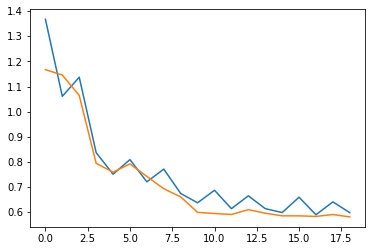

In [27]:
plt.plot(ret.history["loss"])
plt.plot(ret.history["val_loss"])
#plt.ylim(0.2,2) 

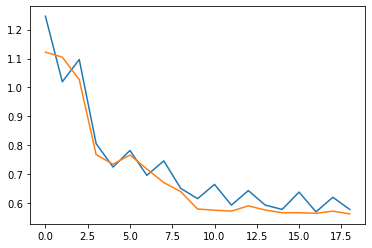

In [28]:
plt.plot(ret.history["loss_simple"])
plt.plot(ret.history["val_loss_simple"])
#plt.ylim(0.2,2) 

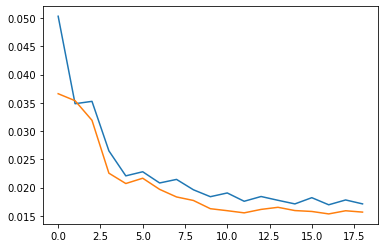

In [29]:
plt.plot(ret.history["loss_etweighted"])
plt.plot(ret.history["val_loss_etweighted"])
#plt.ylim(0.2,2) 

In [30]:
model.layers

In [31]:
a = model.layers[0]

In [32]:
model.layers[0].weights

[<tf.Variable 'Q_sa:0' shape=(10, 10) dtype=float32, numpy=
 array([[-0.8293954 , -0.63745517,  0.1919174 , -0.9091773 , -0.92191064,
          0.6690625 ,  0.86884147,  0.55050814,  0.83633965, -0.6915036 ],
        [-0.0756784 , -0.15353905,  0.1158836 ,  0.28832024,  0.28714144,
         -0.10028498, -0.08615327, -0.3172318 , -0.28740844,  0.0155658 ],
        [ 0.29608896,  0.39155486, -0.06938874, -0.16238952, -0.16730194,
          0.02715301,  0.30697158,  0.18277256,  0.21688618, -0.05762861],
        [-0.9769387 ,  0.24079184, -0.8282103 , -0.04175768,  0.43354356,
          0.92938787, -0.10635448,  0.46497038, -0.19816826,  0.7742252 ],
        [ 0.13155639,  0.42160633, -0.4572141 , -0.1002343 , -0.30607814,
          0.05349021,  0.00997996,  0.36490184, -0.18165925,  0.13270144],
        [-0.38627753, -0.38314345,  0.15472391, -0.2084667 , -0.21516342,
          0.10228775,  0.23358744,  0.02916207,  0.44771522, -0.21147822],
        [-0.26815516, -0.01580755, -0.1248017 

In [69]:
model.load_weights("/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_40/weights.82-1.462194.hdf5")

In [79]:
with open(outdir + "/args.txt",'w') as config:
    config.write(str(args))
    
model.save(outdir+"/model")
    

# Debug model



In [ ]:
#OLd model
